In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

## 数据预处理
### 将数据导入,并且查看数据的基本信息

In [2]:
data = pd.read_csv('./data/heart-disease-uci/heart.csv')
#查看一下基本的信息
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# 没有缺失的数据
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
# 查看一下类别的数目以及种类, 二分类问题, 并且类别比较均衡
np.unique(data['target'], return_counts=True)

(array([0, 1], dtype=int64), array([138, 165], dtype=int64))

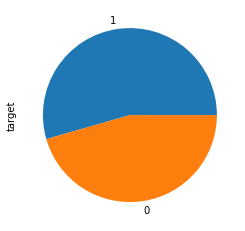

In [5]:
# 绘制类别的饼图
data['target'].value_counts().plot(kind='pie')


In [6]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### 用直方图画出各个变量的分布情况

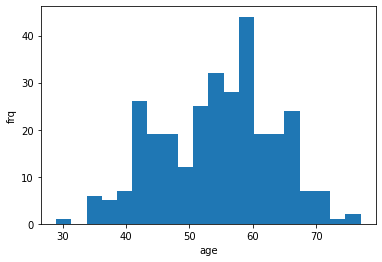

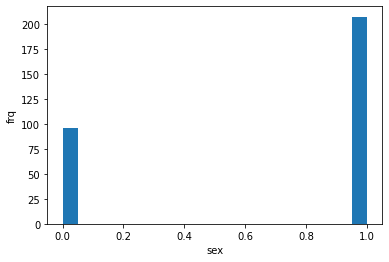

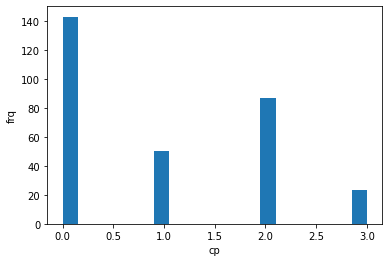

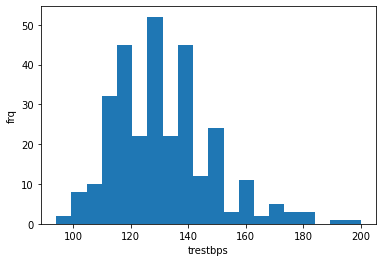

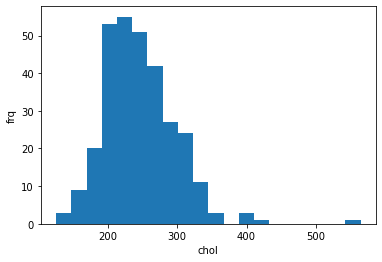

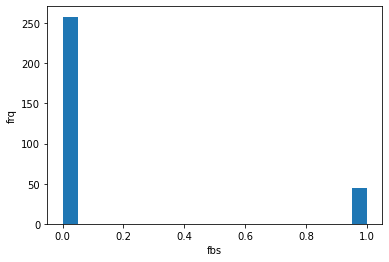

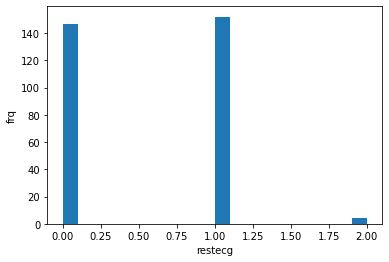

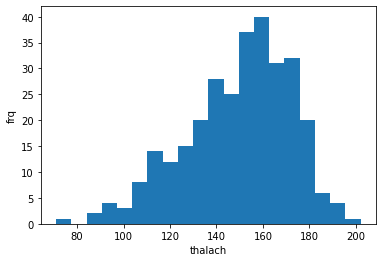

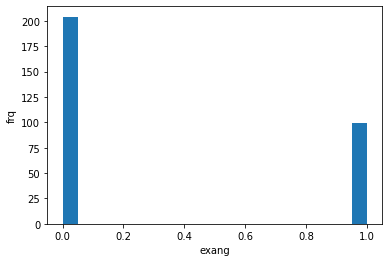

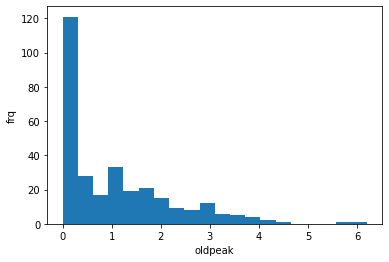

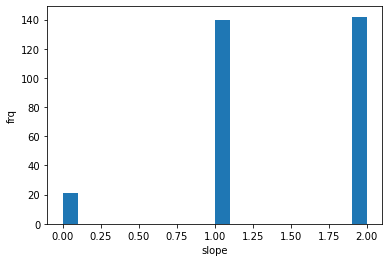

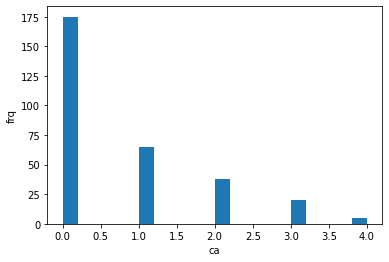

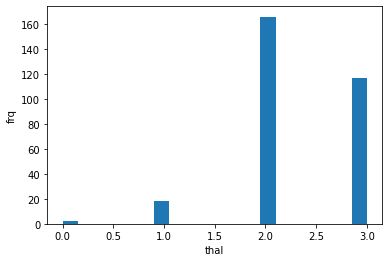

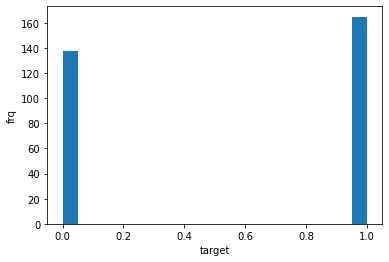

In [7]:
for idx, col in enumerate(data.columns):
    plt.hist(data[col], bins=20)
    plt.xlabel(col)
    plt.ylabel('frq')
    plt.show()

### 变量热力图

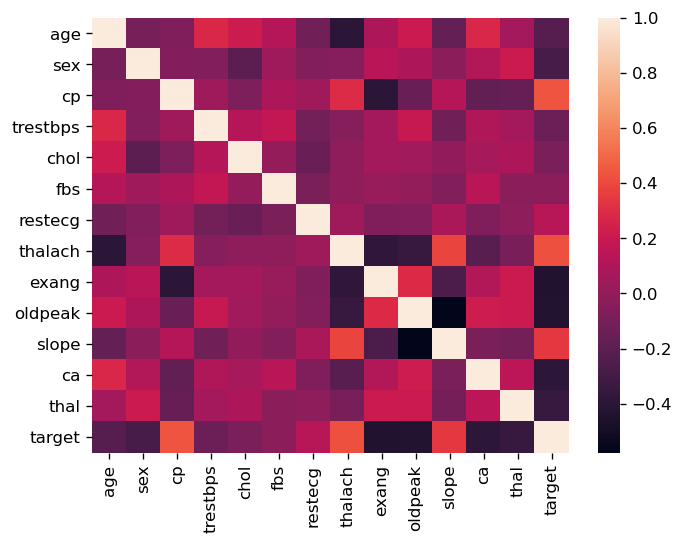

In [8]:
"""
类别变量:
thal
ca
slope
exang
restecg
fbs
cp
sex
"""
class_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
plt.figure(figsize=(6.4,4.8), dpi=120)
sns.heatmap(data.corr())

In [9]:
data.corr()['target']

age        -0.225439
sex        -0.280937
cp          0.433798
trestbps   -0.144931
chol       -0.085239
fbs        -0.028046
restecg     0.137230
thalach     0.421741
exang      -0.436757
oldpeak    -0.430696
slope       0.345877
ca         -0.391724
thal       -0.344029
target      1.000000
Name: target, dtype: float64

### 类别型变量与target之间的关系饼图

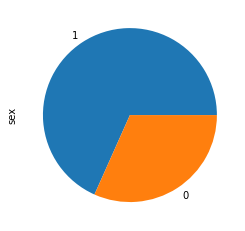

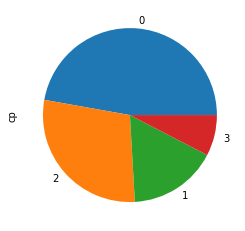

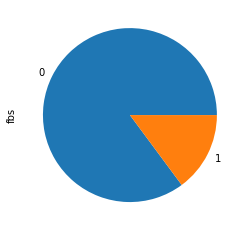

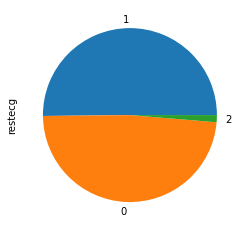

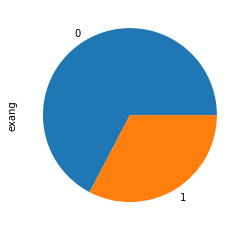

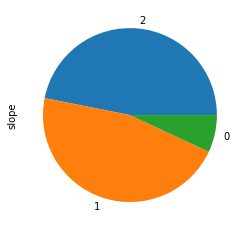

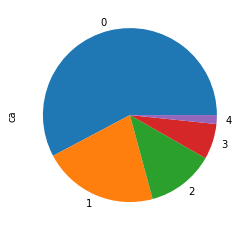

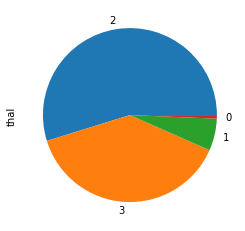

In [10]:
# 画出类别变量与患心脏病之间的关系饼图.
data_target = data.loc[data.target == 1]
for col in class_vars:
    data[col].value_counts().plot(kind='pie')
    plt.show()

通过分析饼图,我们可以发现,是否患心脏病与各个类别型变量的属性均有关系.

将类别型变量构造为虚拟型变量
sex 
cp (0,2) (1,3) 各一组
restecg (1,0)与 2 各一组
slope (1, 2) 与 0 各一组
ca 0 与 其他
thal 2,3 与 其他

### 构造虚拟变量

In [11]:
# MapDict = {
#     'sex':None,
#     'fbs':None,
#     'exang':None,
#     'thal':{2:1, 3:1, 1:0, 0:0},
#     'slope':{2:1,1:1,0:0},
#     'restecg':{2:0, 0:1, 1:1},
#     'ca':{0:0, 0:1,2:0,3:0,4:0},
#     'cp':{0:1,2:1,1:0,3:0},
# }

MapColumns = [ 'sex', 'fbs', 'exang', 'thal', 'slope', 'restecg', 'ca', 'cp']

# def get_dummies(data, **kwargs):
#     tmp_data = data.copy(deep = True)
#     for k, v in kwargs.items():
#         if v:
#             tmp_data[k] = tmp_data[k].map(v)
#             tmp_data = pd.get_dummies(tmp_data, columns = [k])
#         else:
#             tmp_data = pd.get_dummies(tmp_data, columns = [k])
#     return tmp_data

def get_dummies(data, MapColumns):
    tmp_data = data.copy(deep = True)
    for key in MapColumns:
        tmp_data = pd.get_dummies(tmp_data, columns = [key])
    return tmp_data

# df_dummies = get_dummies(data, **MapDict)
df_dummies = get_dummies(data, MapColumns)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        303 non-null    int64  
 1   trestbps   303 non-null    int64  
 2   chol       303 non-null    int64  
 3   thalach    303 non-null    int64  
 4   oldpeak    303 non-null    float64
 5   target     303 non-null    int64  
 6   sex_0      303 non-null    uint8  
 7   sex_1      303 non-null    uint8  
 8   fbs_0      303 non-null    uint8  
 9   fbs_1      303 non-null    uint8  
 10  exang_0    303 non-null    uint8  
 11  exang_1    303 non-null    uint8  
 12  thal_0     303 non-null    uint8  
 13  thal_1     303 non-null    uint8  
 14  thal_2     303 non-null    uint8  
 15  thal_3     303 non-null    uint8  
 16  slope_0    303 non-null    uint8  
 17  slope_1    303 non-null    uint8  
 18  slope_2    303 non-null    uint8  
 19  restecg_0  303 non-null    uint8  
 20  restecg_1 

In [12]:
df_dummies.describe()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,fbs_0,fbs_1,...,restecg_2,ca_0,ca_1,ca_2,ca_3,ca_4,cp_0,cp_1,cp_2,cp_3
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.544554,0.316832,0.683168,0.851485,0.148515,...,0.013201,0.577558,0.214521,0.125413,0.066007,0.016502,0.471947,0.165017,0.287129,0.075908
std,9.082101,17.538143,51.830751,22.905161,1.161075,0.498835,0.466011,0.466011,0.356198,0.356198,...,0.114325,0.494765,0.411169,0.331734,0.248704,0.127605,0.500038,0.371809,0.453171,0.265288
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 分离训练集与测试集

In [13]:
from sklearn.model_selection import train_test_split

X = df_dummies.drop(columns=['target'])
y = df_dummies['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(242, 30) (61, 30) (242,) (61,)


### 对特征进行标准化处理

In [14]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## 训练
### 交叉验证选择最优参数

In [15]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
        self.best = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.best[key] = {'score':gs.best_score_, 'params':gs.best_params_}
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]
    def best_params(self):
        return self.best

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

models = {
    'rf':RandomForestClassifier(),
    'gbdt':GradientBoostingClassifier(),
    'ada':AdaBoostClassifier(),
    'xgb':XGBClassifier(),
    'svm':SVC(),
    'lr':LogisticRegression(),
}

params = {
    'rf':{'n_estimators' : [32,64,96], "max_depth" : [4,6,8]},
    'gbdt':{"n_estimators" : [32,64,96], "max_depth" : [2,4,6], "learning_rate" : [0.1,0.3,0.9]},
    'ada':{"n_estimators" : [32,64,96], "learning_rate" : [0.5,1.0]},
    'xgb':{"max_depth" : [2,4,6], "learning_rate" : [0.1,0.3,0.9]},
    'svm': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ],
    'lr':{'C' : [1, 10]},
}

Helper = EstimatorSelectionHelper(models, params)
Helper.fit(X_train_sc, y_train, cv=5)
Helper.score_summary(sort_by='mean_score')

Running GridSearchCV for rf.
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:    2.0s finished


Running GridSearchCV for gbdt.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 135 out of 135 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for ada.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for xgb.
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for svm.
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Running GridSearchCV for lr.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
rf
gbdt
ada
xgb
svm
lr


,estimator,min_score,mean_score,max_score,std_score,max_depth,n_estimators,learning_rate,C,kernel,gamma
8,rf,0.8125,0.867517,0.897959,0.0370153,8,96,NaN,NaN,NaN,NaN
4,rf,0.791667,0.859269,0.897959,0.0365369,6,64,NaN,NaN,NaN,NaN
6,rf,0.791667,0.859269,0.897959,0.0410143,8,32,NaN,NaN,NaN,NaN
56,svm,0.8125,0.855017,0.918367,0.0403414,NaN,NaN,NaN,10,rbf,0.0001
53,svm,0.8125,0.855017,0.918367,0.0403414,NaN,NaN,NaN,1,rbf,0.001
5,rf,0.8125,0.851105,0.877551,0.0249519,6,96,NaN,NaN,NaN,NaN
2,rf,0.8125,0.85102,0.877551,0.0253547,4,96,NaN,NaN,NaN,NaN
1,rf,0.791667,0.846769,0.897959,0.0395811,4,64,NaN,NaN,NaN,NaN
55,svm,0.791667,0.846684,0.918367,0.0493985,NaN,NaN,NaN,10,rbf,0.001
52,svm,0.791667,0.842687,0.897959,0.0347622,NaN,NaN,NaN,10,linear,NaN


In [17]:
best = Helper.best_params()
best

{'rf': {'score': 0.867517006802721,
  'params': {'max_depth': 8, 'n_estimators': 96}},
 'gbdt': {'score': 0.8303571428571429,
  'params': {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 32}},
 'ada': {'score': 0.8177721088435375,
  'params': {'learning_rate': 0.5, 'n_estimators': 32}},
 'xgb': {'score': 0.8426870748299319,
  'params': {'learning_rate': 0.1, 'max_depth': 2}},
 'svm': {'score': 0.855017006802721,
  'params': {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}},
 'lr': {'score': 0.8385204081632655, 'params': {'C': 10}}}

### 设置最优参数


In [18]:
best_models = [
    ('rf',RandomForestClassifier()),
    ('gbdt',GradientBoostingClassifier()),
    ('ada',AdaBoostClassifier()),
    ('xgb',XGBClassifier()),
    ('svm',SVC()),
    ('lr',LogisticRegression()),
]

for item in best_models:
    key, clf = item
    clf.set_params(**best[key]['params'])

In [19]:
from sklearn.ensemble import VotingClassifier
vote_hard = VotingClassifier(estimators = best_models , voting = 'hard')
vote_hard.fit(X_train_sc, y_train)
prediction = vote_hard.predict(X_test_sc)

### 计算准确率

In [20]:
correct = (prediction == y_test).sum()
accuracy = correct / len(y_test)

In [21]:
print(f'accuracy {accuracy}')

accuracy 0.7377049180327869


### 编写一个pipeline

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
steps = [
    ('pca',PCA()),
    ('vote_clf',vote_hard),
]

params = {
    'pca__n_components':[6,12,18]
}

pipeline = Pipeline(steps)

gs = GridSearchCV(pipeline, params, cv = 5)
gs.fit(X_train_sc, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('vote_clf',
                                        VotingClassifier(estimators=[('rf',
                                                                      RandomForestClassifier(bootstrap=True,
                                                                                             ccp_alpha=0.0,
                                                                                             class_weight=None,
                                                                               

In [23]:
gs.best_params_

{'pca__n_components': 12}

In [24]:
gs.best_score_

0.863265306122449

### 设置PCA超参数

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=gs.best_params_['pca__n_components'])
X_train_d = pca.fit_transform(X_train_sc)
X_test_d = pca.transform(X_test_sc)

In [26]:
vote_hard.fit(X_train_d, y_train)
prediction = vote_hard.predict(X_test_d)
correct = (prediction == y_test).sum()
accuracy = correct / len(y_test)
print(f'accuracy {accuracy}')

accuracy 0.7704918032786885
